In [66]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit 
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import classification_report


import timeit
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

In [67]:
# display plots in notebook
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 14,
         'axes.titlesize': 20,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14}
plt.rcParams.update(params)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [101]:
def convert_column_type(df):
    return df.select(*(col(c).cast(DoubleType()).alias(c) for c in df.columns))

def whether_take_med(x):
    if x in ['dominant_med', 'non_dominant_med']:
        return 1
    elif x in ['dominant_water', 'non_dominant_water']:
        return 2
    elif x in ['dominant_walk', 'non_dominant_walk']:
        return 3
    elif x in ['dominant_write', 'non_dominant_write']:
        return 4
    elif x in ['dominant_text', 'non_dominant_text']:
        return 5

def get_csv(directory):
    """
    given a directory, return the path of the first csv file under each directory
    """
    csv_list = []
    for dirpath, dirnames, files in os.walk(directory):
        for file_ in files:
            if file_[-3:] == 'csv' and 'discretizaed' in file_:
                csv_list.append(os.path.join(dirpath, file_))
    return csv_list

In [107]:
# start a spark session
spark = SparkSession.builder \
    .appName("MediWatch") \
    .master("local[4]") \
    .config(conf=SparkConf()) \
    .getOrCreate()
        
def pipeline_mediwatch(filename):
    # read data
    df_motion = spark.read \
                 .format("csv") \
                 .option("delimiter", ",") \
                 .load(filename)

    # create response variable
    med_flag = udf(lambda x: whether_take_med(x))
    df_motion_with_response = df_motion.withColumn('label', med_flag('_c0')).drop('_c0')

    # convert feature type from string to float
    df_motion_with_response = convert_column_type(df_motion_with_response)
    
    # split data into training and test set using stratified split
    data_with_index = df_motion_with_response.withColumn('index', monotonically_increasing_id())
    label_index_df = data_with_index.select(['label', 'index']).toPandas()
    train_idx = []
    test_idx = []

    split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42) 

    train_idx =[]
    test_idx = []
    for train_index, test_index in split.split(label_index_df, label_index_df['label']): 
        train_idx = train_index
        test_idx = test_index

    data_train = data_with_index.where(data_with_index['index'].isin(list(train_idx))).drop('index')
    data_test = data_with_index.where(data_with_index['index'].isin(list(test_idx))).drop('index')

    # prepare the data for machine learning
    vectorAssembler = VectorAssembler(inputCols=data_train.columns[:-1], outputCol='features')
    data_train = vectorAssembler.transform(data_train).select('label', 'features')
    data_test = vectorAssembler.transform(data_test).select('label', 'features')

    labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data_with_index)
    labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                                   labels=labelIndexer.labels)

    # train model
    rf = RandomForestClassifier(labelCol='indexedLabel', featuresCol='features', numTrees=50)
    pipeline = Pipeline(stages=[labelIndexer, rf, labelConverter]) 

    start = timeit.default_timer()
    model = pipeline.fit(data_train)
    stop = timeit.default_timer()    

    # make predictions
    predictions = model.transform(data_test)
    metrics_rf = MulticlassMetrics(predictions.select('prediction', 'indexedLabel').rdd)
    
    y_pred = [float(i.prediction) for i in predictions.collect()]
    y_label = [float(i.indexedLabel) for i in predictions.collect()]
    
    # return precision, recall, and run time
    return (stop - start, y_label, y_pred)

In [118]:
directory = '/Users/jinxin/Dropbox/MSAN/MediWatch/MediWatch'
csv_ls = get_csv(directory)
csv_ls = csv_ls[3:7]
csv_ls.remove(csv_ls[1])
csv_ls

['/Users/jinxin/Dropbox/MSAN/MediWatch/MediWatch/discretizaed_data_40.csv',
 '/Users/jinxin/Dropbox/MSAN/MediWatch/MediWatch/discretizaed_data_50.csv',
 '/Users/jinxin/Dropbox/MSAN/MediWatch/MediWatch/discretizaed_data_60.csv']

In [119]:
final_result_new = {}
for file_ in csv_ls:
    final_result_new[file_[-6:-4]] = pipeline_mediwatch(file_)

## 5 bins

('model training time (in seconds): ', 2.5243380069732666)

class 0 - 4 correspond to med, walk, water, write, and text
             precision    recall  f1-score   support

        0.0       0.75      1.00      0.86        12
        1.0       1.00      0.83      0.91         6
        2.0       1.00      0.50      0.67         6
        3.0       1.00      1.00      1.00         6
        4.0       1.00      1.00      1.00         5

avg / total       0.91      0.89      0.88        35

Confusion matrix, without normalization
[[12  0  0  0  0]
 [ 1  5  0  0  0]
 [ 3  0  3  0  0]
 [ 0  0  0  6  0]
 [ 0  0  0  0  5]]


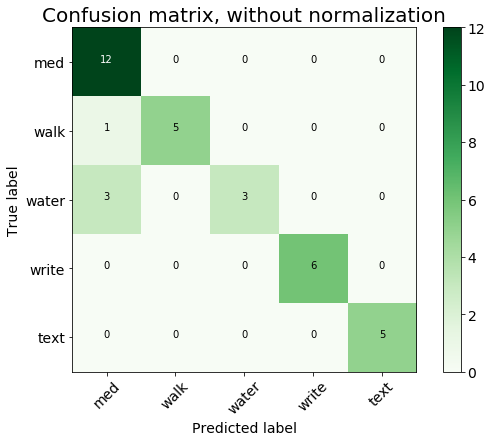

In [57]:
print ('model training time (in seconds): ', final_result['_5'][2])
print''
print 'class 0 - 4 correspond to med, walk, water, write, and text'
print classification_report(final_result['_5'][3], final_result['_5'][4])

cnf_matrix = confusion_matrix(final_result['_5'][3], final_result['_5'][4])
plot_confusion_matrix(cnf_matrix, classes=['med', 'walk', 'water', 'write', 'text'],
                      title='Confusion matrix, without normalization')

## 10 bins

('model training time (in seconds): ', 6.248517036437988)
             precision    recall  f1-score   support

        0.0       0.75      1.00      0.86        12
        1.0       1.00      0.83      0.91         6
        2.0       1.00      0.67      0.80         6
        3.0       1.00      0.83      0.91         6
        4.0       1.00      1.00      1.00         5

avg / total       0.91      0.89      0.89        35

Confusion matrix, without normalization
[[12  0  0  0  0]
 [ 1  5  0  0  0]
 [ 2  0  4  0  0]
 [ 1  0  0  5  0]
 [ 0  0  0  0  5]]


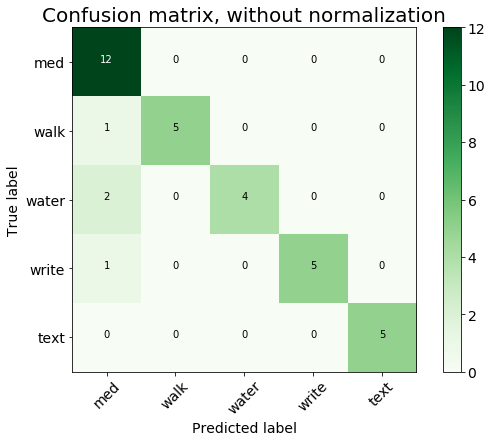

In [58]:
print ('model training time (in seconds): ', final_result['10'][2])
print classification_report(final_result['10'][3], final_result['10'][4])

cnf_matrix = confusion_matrix(final_result['10'][3], final_result['10'][4])
plot_confusion_matrix(cnf_matrix, classes=['med', 'walk', 'water', 'write', 'text'],
                      title='Confusion matrix, without normalization')

## 20 bins

('model training time (in seconds): ', 22.6836040019989)
             precision    recall  f1-score   support

        0.0       0.63      1.00      0.77        12
        1.0       1.00      0.83      0.91         6
        2.0       1.00      0.33      0.50         6
        3.0       1.00      0.67      0.80         6
        4.0       1.00      1.00      1.00         5

avg / total       0.87      0.80      0.79        35

Confusion matrix, without normalization
[[12  0  0  0  0]
 [ 1  5  0  0  0]
 [ 4  0  2  0  0]
 [ 2  0  0  4  0]
 [ 0  0  0  0  5]]


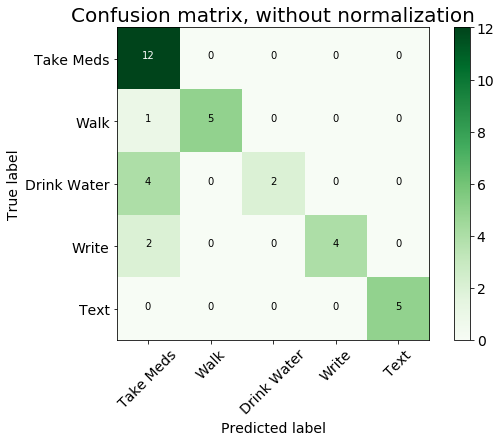

In [63]:
print ('model training time (in seconds): ', final_result['20'][2])
print classification_report(final_result['20'][3], final_result['20'][4])

cnf_matrix = confusion_matrix(final_result['20'][3], final_result['20'][4])
plot_confusion_matrix(cnf_matrix, classes=['Take Meds', 'Walk', 'Drink Water', 'Write', 'Text'],
                      title='Confusion matrix, without normalization')

## 30 bins

('model training time (in seconds): ', 60.45088791847229)
             precision    recall  f1-score   support

        0.0       0.80      1.00      0.89        12
        1.0       1.00      0.83      0.91         6
        2.0       1.00      0.83      0.91         6
        3.0       0.83      0.83      0.83         6
        4.0       1.00      0.80      0.89         5

avg / total       0.90      0.89      0.89        35

Confusion matrix, without normalization
[[12  0  0  0  0]
 [ 1  5  0  0  0]
 [ 1  0  5  0  0]
 [ 1  0  0  5  0]
 [ 0  0  0  1  4]]


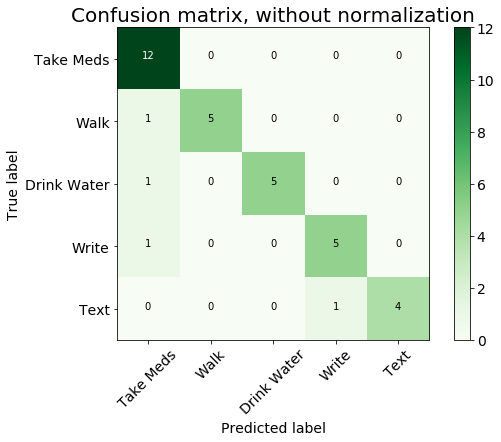

In [65]:
print ('model training time (in seconds): ', final_result['30'][2])
print classification_report(final_result['30'][3], final_result['30'][4])

cnf_matrix = confusion_matrix(final_result['30'][3], final_result['30'][4])
plot_confusion_matrix(cnf_matrix, classes=['Take Meds', 'Walk', 'Drink Water', 'Write', 'Text'],
                      title='Confusion matrix, without normalization')

## 40 bins

('model training time (in seconds): ', 161.14841318130493)

class 0 - 4 correspond to med, walk, water, write, and text
             precision    recall  f1-score   support

        0.0       0.80      1.00      0.89        12
        1.0       1.00      0.83      0.91         6
        2.0       1.00      0.83      0.91         6
        3.0       1.00      0.83      0.91         6
        4.0       1.00      1.00      1.00         5

avg / total       0.93      0.91      0.92        35

Confusion matrix, without normalization
[[12  0  0  0  0]
 [ 1  5  0  0  0]
 [ 1  0  5  0  0]
 [ 1  0  0  5  0]
 [ 0  0  0  0  5]]


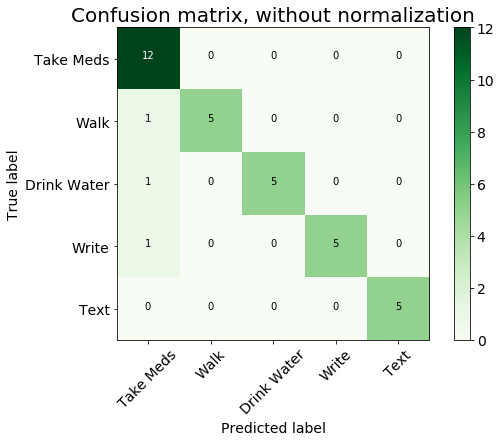

In [120]:
print ('model training time (in seconds): ', final_result_new['40'][0])
print''
print 'class 0 - 4 correspond to med, walk, water, write, and text'
print classification_report(final_result_new['40'][1], final_result_new['40'][2])

cnf_matrix = confusion_matrix(final_result_new['40'][1], final_result_new['40'][2])
plot_confusion_matrix(cnf_matrix, classes=['Take Meds', 'Walk', 'Drink Water', 'Write', 'Text'],
                      title='Confusion matrix, without normalization')

## 50 bins

('model training time (in seconds): ', 352.71069598197937)

class 0 - 4 correspond to med, walk, water, write, and text
             precision    recall  f1-score   support

        0.0       0.80      1.00      0.89        12
        1.0       1.00      0.83      0.91         6
        2.0       1.00      1.00      1.00         6
        3.0       1.00      0.67      0.80         6
        4.0       1.00      1.00      1.00         5

avg / total       0.93      0.91      0.91        35

Confusion matrix, without normalization
[[12  0  0  0  0]
 [ 1  5  0  0  0]
 [ 0  0  6  0  0]
 [ 2  0  0  4  0]
 [ 0  0  0  0  5]]


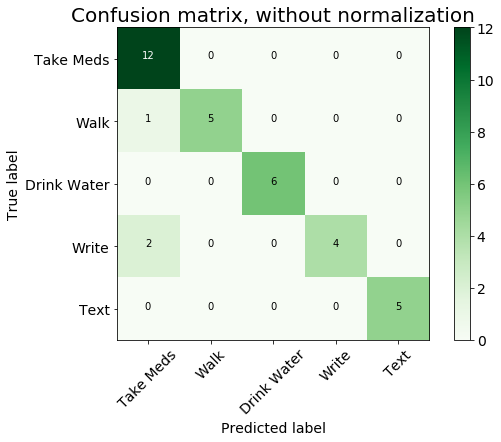

In [121]:
print ('model training time (in seconds): ', final_result_new['50'][0])
print''
print 'class 0 - 4 correspond to med, walk, water, write, and text'
print classification_report(final_result_new['50'][1], final_result_new['50'][2])

cnf_matrix = confusion_matrix(final_result_new['50'][1], final_result_new['50'][2])
plot_confusion_matrix(cnf_matrix, classes=['Take Meds', 'Walk', 'Drink Water', 'Write', 'Text'],
                      title='Confusion matrix, without normalization')

## 60 bins

('model training time (in seconds): ', 457.3988199234009)

class 0 - 4 correspond to med, walk, water, write, and text
             precision    recall  f1-score   support

        0.0       0.75      1.00      0.86        12
        1.0       1.00      0.83      0.91         6
        2.0       1.00      0.83      0.91         6
        3.0       1.00      0.67      0.80         6
        4.0       1.00      1.00      1.00         5

avg / total       0.91      0.89      0.89        35

Confusion matrix, without normalization
[[12  0  0  0  0]
 [ 1  5  0  0  0]
 [ 1  0  5  0  0]
 [ 2  0  0  4  0]
 [ 0  0  0  0  5]]


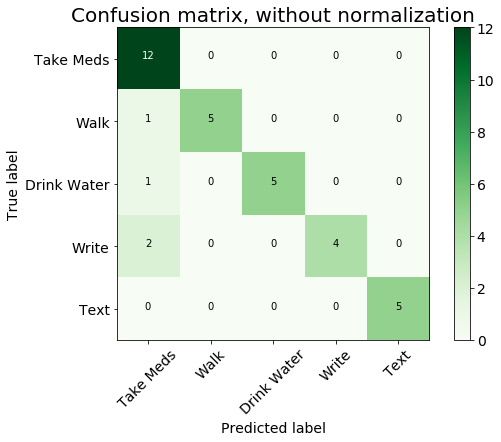

In [122]:
print ('model training time (in seconds): ', final_result_new['60'][0])
print''
print 'class 0 - 4 correspond to med, walk, water, write, and text'
print classification_report(final_result_new['60'][1], final_result_new['60'][2])

cnf_matrix = confusion_matrix(final_result_new['60'][1], final_result_new['60'][2])
plot_confusion_matrix(cnf_matrix, classes=['Take Meds', 'Walk', 'Drink Water', 'Write', 'Text'],
                      title='Confusion matrix, without normalization')